In [26]:
import pandas as pd
file_path = 'hipparcos_star_features.csv' # Or the subset file
df = pd.read_csv(file_path)
print("First 5 rows:\n", df.head())
print("\nColumn names:\n", df.columns.tolist())

First 5 rows:
     HIP   Plx   pmRA   pmDE  res_mean    res_std  res_range  n_measurements
0  2382 -1.03  -5.46  -1.24  0.448701  12.938191      79.83             154
1  2547  8.45  35.96  -3.90 -0.293125   4.333877      21.61              80
2  4415  1.96  17.68  12.15  0.066475   6.019917      38.06             122
3  5123  2.17  15.29  -9.57  0.044944   5.137148      29.86              89
4  6715  6.95  34.94  14.02 -0.751351   3.742633      16.60              74

Column names:
 ['HIP', 'Plx', 'pmRA', 'pmDE', 'res_mean', 'res_std', 'res_range', 'n_measurements']


Amplitude K: 1052.43 m/s
Reduced chi-squared: 7114.24


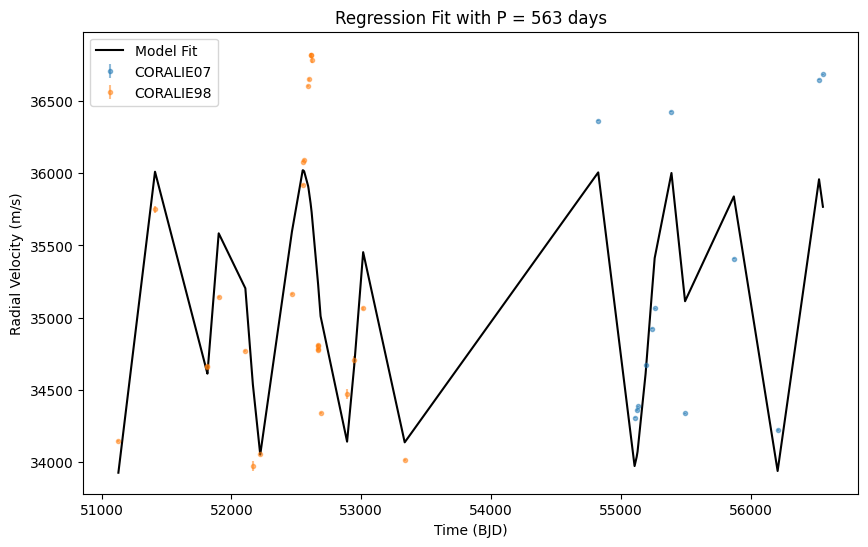

In [27]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dace_query.spectroscopy import Spectroscopy

# Step 1: Retrieve RV data from DACE for HD 17289
rv_data = (
    Spectroscopy.query_database(
        filters={
            "obj_id_catname": {"contains": ["HD17289"]},
            "ins_name": {"contains": ["CORALIE98", "CORALIE07"]},
            "spectro_ccf_rv_err": {"max": 50},
        },
        output_format="pandas"
    )
    .sort_values("obj_date_bjd")
    .reset_index(drop=True)
)

# Step 2: Extract necessary columns from the retrieved data
t = rv_data['obj_date_bjd'].values          # Observation times (BJD)
v = rv_data['spectro_ccf_rv'].values        # Radial velocities (m/s)
sigma = rv_data['spectro_ccf_rv_err'].values # RV errors (m/s)
instruments = rv_data['ins_name'].values     # Instrument names

# Step 3: Define the period for the periodic signal (example value)
P = 563  # Period in days (based on prior analysis or hypothesis)
omega = 2 * np.pi / P  # Angular frequency

# Step 4: Create sine and cosine features for the regression
sin_term = np.sin(omega * t)
cos_term = np.cos(omega * t)

# Step 5: Create dummy variables for instruments to account for offsets
instrument_dummies = pd.get_dummies(instruments, prefix='inst')

# Step 6: Build the design matrix with sine, cosine, and instrument terms
X = np.column_stack([sin_term, cos_term] + 
                    [instrument_dummies[col].values for col in instrument_dummies.columns])

# Step 7: Define weights based on RV measurement errors
weights = 1 / sigma**2

# Step 8: Perform weighted least squares regression
W = np.diag(weights)
X_weighted = W @ X
y_weighted = W @ v
beta, _, _, _ = np.linalg.lstsq(X_weighted, y_weighted, rcond=None)

# Step 9: Extract model coefficients
a, b = beta[0], beta[1]  # Coefficients for sine and cosine terms
offsets = beta[2:]        # Instrument-specific offsets

# Step 10: Compute the predicted RV values
y_pred = X @ beta

# Step 11: Calculate residuals
residuals = v - y_pred

# Step 12: Compute the amplitude of the periodic signal
K = np.sqrt(a**2 + b**2)
print(f"Amplitude K: {K:.2f} m/s")

# Step 13: Compute reduced chi-squared to evaluate fit quality
chi2 = np.sum((residuals / sigma)**2)
dof = len(v) - len(beta)  # Degrees of freedom
reduced_chi2 = chi2 / dof
print(f"Reduced chi-squared: {reduced_chi2:.2f}")

# Step 14: Plot the data and the fitted model
plt.figure(figsize=(10, 6))
for inst in np.unique(instruments):
    mask = instruments == inst
    plt.errorbar(t[mask], v[mask], yerr=sigma[mask], fmt='.', label=inst, alpha=0.5)
plt.plot(t, y_pred, 'k-', label='Model Fit')
plt.xlabel('Time (BJD)')
plt.ylabel('Radial Velocity (m/s)')
plt.title(f'Regression Fit with P = {P} days')
plt.legend()
plt.show()

## Once I get the API KEY

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Keep your original functions unchanged
def fit_sinusoid_and_offsets(t, v, sigma, instruments, P):
    """
    Performs a weighted least squares fit for a sinusoid + instrument offsets
    at a given period P.
    """
    omega = 2 * np.pi / P
    sin_term = np.sin(omega * t)
    cos_term = np.cos(omega * t)
    instrument_dummies = pd.get_dummies(instruments, prefix='inst')
    X = np.column_stack([sin_term, cos_term] +
                        [instrument_dummies[col].values for col in instrument_dummies.columns])
    weights = 1 / sigma**2
    W = np.diag(weights)
    try:
        X_inv = np.linalg.pinv(X.T @ W @ X)
        beta = X_inv @ (X.T @ W @ v)
        y_pred = X @ beta
        residuals = v - y_pred
        chi2 = np.sum((residuals * np.sqrt(weights))**2)
        dof = len(v) - len(beta)
        return beta, chi2, dof, X
    except np.linalg.LinAlgError:
        print(f"Warning: Linear algebra error during fit at P={P:.2f}. Skipping period.")
        return None, np.inf, len(v) - X.shape[1] if X.shape[1] < len(v) else 0, X

def calculate_periodogram_power(t, v, sigma, instruments, periods):
    """
    Calculates a measure of periodogram power by comparing chi-squared
    of a sinusoidal fit vs. a fit with only offsets.
    """
    instrument_dummies = pd.get_dummies(instruments, prefix='inst')
    X_null = np.column_stack([instrument_dummies[col].values for col in instrument_dummies.columns])
    weights = 1 / sigma**2
    W = np.diag(weights)
    try:
        X_null_inv = np.linalg.pinv(X_null.T @ W @ X_null)
        beta_null = X_null_inv @ (X_null.T @ W @ v)
        y_pred_null = X_null @ beta_null
        residuals_null = v - y_pred_null
        chi2_null = np.sum((residuals_null * np.sqrt(weights))**2)
    except np.linalg.LinAlgError:
        print("Warning: Could not fit null model (offsets only).")
        return periods, np.zeros_like(periods) * np.nan

    power = []
    valid_periods = []
    print(f"Scanning {len(periods)} periods...")
    for i, P in enumerate(periods):
        beta, chi2_fit, dof_fit, _ = fit_sinusoid_and_offsets(t, v, sigma, instruments, P)
        if beta is not None and dof_fit > 0:
            current_power = (chi2_null - chi2_fit) / chi2_null if chi2_null > 0 else 0
            power.append(max(0, current_power))
            valid_periods.append(P)
    print("Scan complete.")
    return np.array(valid_periods), np.array(power)

def analyze_star_rv(star_name, csv_file_path, P_min=1, P_max=10000, num_periods=5000):
    """
    Loads RV data from a CSV file and performs a period scan.
    """
    print(f"\n--- Analyzing Star: {star_name} ---")
    # Step 1: Load RV data from CSV
    print("Loading RV data from CSV...")
    try:
        rv_data = pd.read_csv(csv_file_path).sort_values("obj_date_bjd").reset_index(drop=True)
        print(f"Found {len(rv_data)} RV measurements.")
        if len(rv_data) < 5:
            print("Insufficient data points to perform analysis.")
            return None
    except Exception as e:
        print(f"Error loading data for {star_name} from {csv_file_path}: {e}")
        return None

    # Step 2: Extract data (adjust column names if necessary)
    # If your CSV has different column names, rename them here
    # Example: rv_data.rename(columns={'time': 'obj_date_bjd', 'rv': 'spectro_ccf_rv', 
    #                                  'rv_err': 'spectro_ccf_rv_err', 'instrument': 'ins_name'}, inplace=True)
    t = rv_data['obj_date_bjd'].values
    v = rv_data['spectro_ccf_rv'].values
    sigma = rv_data['spectro_ccf_rv_err'].values
    instruments = rv_data['ins_name'].values

    # Clean data: Remove NaN/inf in v or sigma, ensure sigma > 0
    valid_mask = np.isfinite(v) & np.isfinite(sigma) & (sigma > 0)
    if np.sum(~valid_mask) > 0:
        print(f"Removing {np.sum(~valid_mask)} invalid data points (NaN/inf error or non-positive error).")
        t = t[valid_mask]
        v = v[valid_mask]
        sigma = sigma[valid_mask]
        instruments = instruments[valid_mask]
        if len(t) < 5:
            print("Insufficient valid data points after cleaning.")
            return None

    # Step 3: Define period range
    periods = np.logspace(np.log10(P_min), np.log10(P_max), num_periods)

    # Step 4: Calculate periodogram power
    scanned_periods, power = calculate_periodogram_power(t, v, sigma, instruments, periods)

    if len(scanned_periods) == 0:
        print("Periodogram calculation failed.")
        return None

    # Step 5: Find the peak period
    max_power_idx = np.argmax(power)
    best_period = scanned_periods[max_power_idx]
    max_power = power[max_power_idx]
    print(f"Highest peak found at Period = {best_period:.3f} days with Power = {max_power:.3f}")

    # Step 6: Fit the model at the best period
    best_beta, best_chi2, best_dof, best_X = fit_sinusoid_and_offsets(t, v, sigma, instruments, best_period)
    if best_beta is not None and best_dof > 0:
        a, b = best_beta[0], best_beta[1]
        K = np.sqrt(a**2 + b**2)
        reduced_chi2 = best_chi2 / best_dof
        print(f"  Fit at best period: K = {K:.2f} m/s, reduced_chi2 = {reduced_chi2:.2f}")

        # Step 7: Plot results
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(scanned_periods, power, 'k-', lw=1)
        plt.scatter(best_period, max_power, color='red', zorder=5, label=f'P = {best_period:.2f} d')
        plt.xscale('log')
        plt.xlabel('Period (days)')
        plt.ylabel('Periodogram Power (relative)')
        plt.title(f'{star_name} - Periodogram')
        plt.legend()

        plt.subplot(1, 2, 2)
        phase = (t / best_period) % 1.0
        t_phase = np.linspace(0, best_period, 500)
        omega_best = 2 * np.pi / best_period
        y_pred_best = best_X @ best_beta
        for inst in np.unique(instruments):
            mask = instruments == inst
            inst_offset_idx = list(pd.get_dummies(instruments, prefix='inst').columns).index(f'inst_{inst}')
            inst_offset_val = best_beta[2 + inst_offset_idx]
            plt.errorbar(phase[mask], v[mask] - inst_offset_val, yerr=sigma[mask], fmt='.', label=inst, alpha=0.6)
        model_curve = a * np.sin(omega_best * t_phase) + b * np.cos(omega_best * t_phase)
        plt.plot(t_phase / best_period, model_curve, 'r--', label='Fitted Sinusoid')
        plt.xlabel(f'Phase (P = {best_period:.2f} days)')
        plt.ylabel('RV - Instrument Offset (m/s)')
        plt.title(f'{star_name} - Phase Folded')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Could not perform final fit at best period.")
        plt.figure(figsize=(7, 5))
        plt.plot(scanned_periods, power, 'k-', lw=1)
        plt.scatter(best_period, max_power, color='red', zorder=5, label=f'P = {best_period:.2f} d')
        plt.xscale('log')
        plt.xlabel('Period (days)')
        plt.ylabel('Periodogram Power (relative)')
        plt.title(f'{star_name} - Periodogram')
        plt.legend()
        plt.show()

    print(f"--- Analysis Complete for {star_name} ---")
    return best_period, max_power

# --- Example Usage ---
target_star = "HD 17289"
csv_file = "hd17289_rv_data.csv"  # Replace with your actual file path
results = analyze_star_rv(target_star, csv_file)

if results:
    print(f"\nSummary for {target_star}: Best Period={results[0]:.3f}, Max Power={results[1]:.3f}")


--- Analyzing Star: HD 17289 ---
Loading RV data from CSV...
Error loading data for HD 17289 from hd17289_rv_data.csv: [Errno 2] No such file or directory: 'hd17289_rv_data.csv'


In [29]:
import pandas as pd

# Read the .rdb file (tab-separated)
data = pd.read_csv('HD 17289_SmoothModel.rdb', sep='\t')

# Save as CSV
data.to_csv('HD 17289_SmoothModel.csv', index=False)

Linear Regression: vrad = -0.1057 * rjd + 40672.20
R^2 (Linear): 0.1515
Estimated Period from Periodogram: 89.86 days
Sinusoidal Fit: vrad = 191.07 * sin(2π * rjd / 89.25 + -25.06) + 34995.23
R^2 (Sinusoidal): 0.0806
Amplitude (K): 191.07 m/s, Period (P): 89.25 days


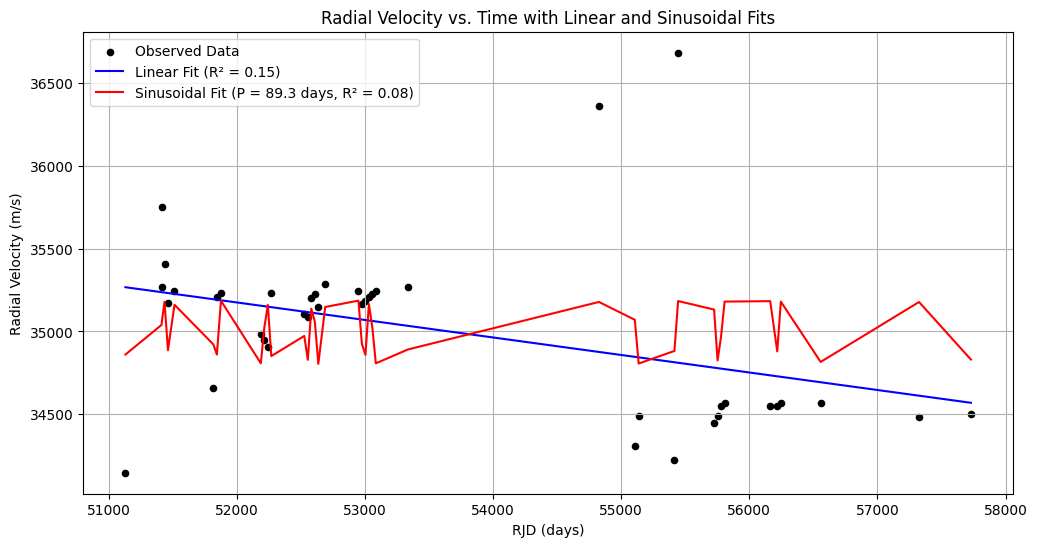

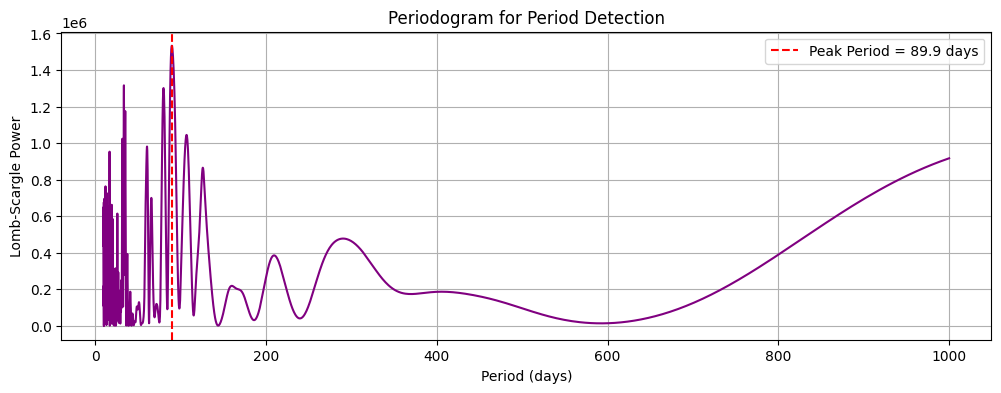

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import lombscargle

# Step 1: Combine the observed data from Documents 1, 2, and 6
data_doc1 = [
    [54825.62970396, 36363.285933], [55105.76652554, 34306.805559], [55135.73754879, 34487.026370],
    [55414.89493338, 34222.026370], [55443.82919142, 36683.180159], [55724.92052929, 34447.026370],
    [55751.89493338, 34487.026370], [55778.82919142, 34547.026370], [55806.76652554, 34567.026370],
    [56162.92052929, 34547.026370], [56217.89493338, 34547.026370], [56245.82919142, 34567.026370],
    [56556.84090049, 34567.026370]
]
data_doc2 = [
    [57324.73754879, 34482.154051], [57729.64884533, 34502.154051]
]
data_doc6 = [
    [51128.69988344, 34146.745232], [51410.91666112, 35749.382131], [51411.92052929, 35265.886107],
    [51433.88845277, 35406.345182], [51460.81172707, 35172.737581], [51511.76594888, 35242.976813],
    [51814.79229856, 34657.495920], [51842.70208705, 35207.526676], [51874.66810881, 35234.099225],
    [52185.82919142, 34986.805379], [52212.73754879, 34948.767092], [52240.66810881, 34904.420766],
    [52267.61736113, 35232.425503], [52524.89493338, 35105.026676], [52552.82574727, 35088.805379],
    [52579.76652554, 35202.099225], [52607.70208705, 35226.099225], [52634.64884533, 35146.745232],
    [52688.61736113, 35288.420766], [52947.89493338, 35246.745232], [52974.82919142, 35166.745232],
    [53002.76594888, 35186.745232], [53029.70208705, 35206.745232], [53056.64884533, 35226.745232],
    [53083.61736113, 35246.745232], [53334.66810881, 35266.745232]
]

# Combine into a single list and convert to DataFrame
combined_data = data_doc1 + data_doc2 + data_doc6
df = pd.DataFrame(combined_data, columns=['rjd', 'vrad'])
df = df.sort_values('rjd').reset_index(drop=True)

# Step 2: Simple Linear Regression
X = df['rjd'].values
y = df['vrad'].values
slope, intercept = np.polyfit(X, y, 1)  # Linear fit (degree 1)
linear_fit = slope * X + intercept
r2_linear = 1 - np.sum((y - linear_fit)**2) / np.sum((y - np.mean(y))**2)

print(f"Linear Regression: vrad = {slope:.4f} * rjd + {intercept:.2f}")
print(f"R^2 (Linear): {r2_linear:.4f}")

# Step 3: Sinusoidal Model for Exoplanet Detection
# Define sinusoidal function: vrad = K * sin(2π * rjd / P + φ) + γ
def sinusoidal(t, K, P, phi, gamma):
    return K * np.sin(2 * np.pi * t / P + phi) + gamma

# Periodogram to estimate possible periods
freqs = np.linspace(0.001, 0.1, 10000)  # Frequency range (1/1000 to 1/10 days^-1)
periods = 1 / freqs  # Convert to periods (10 to 1000 days)
power = lombscargle(X - X.min(), y - np.mean(y), freqs, precenter=True)
best_period = periods[np.argmax(power)]
print(f"Estimated Period from Periodogram: {best_period:.2f} days")

# Fit sinusoidal model using the estimated period as initial guess
initial_guess = [np.std(y), best_period, 0, np.mean(y)]  # [K, P, phi, gamma]
popt, pcov = curve_fit(sinusoidal, X, y, p0=initial_guess, maxfev=10000)
K, P, phi, gamma = popt
sine_fit = sinusoidal(X, K, P, phi, gamma)
r2_sine = 1 - np.sum((y - sine_fit)**2) / np.sum((y - np.mean(y))**2)

print(f"Sinusoidal Fit: vrad = {K:.2f} * sin(2π * rjd / {P:.2f} + {phi:.2f}) + {gamma:.2f}")
print(f"R^2 (Sinusoidal): {r2_sine:.4f}")
print(f"Amplitude (K): {K:.2f} m/s, Period (P): {P:.2f} days")

# Step 4: Visualization
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='black', label='Observed Data', s=20)
plt.plot(X, linear_fit, color='blue', label=f'Linear Fit (R² = {r2_linear:.2f})')
plt.plot(X, sine_fit, color='red', label=f'Sinusoidal Fit (P = {P:.1f} days, R² = {r2_sine:.2f})')
plt.xlabel('RJD (days)')
plt.ylabel('Radial Velocity (m/s)')
plt.title('Radial Velocity vs. Time with Linear and Sinusoidal Fits')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Periodogram Plot
plt.figure(figsize=(12, 4))
plt.plot(periods, power, color='purple')
plt.xlabel('Period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.title('Periodogram for Period Detection')
plt.axvline(best_period, color='red', linestyle='--', label=f'Peak Period = {best_period:.1f} days')
plt.legend()
plt.grid(True)
plt.show()

# Polynomial Regression

Polynomial (degree 2) Coefficients: [-4.16739507e-05  4.40709151e+00 -8.13400053e+04]
R^2 (Polynomial): 0.2039


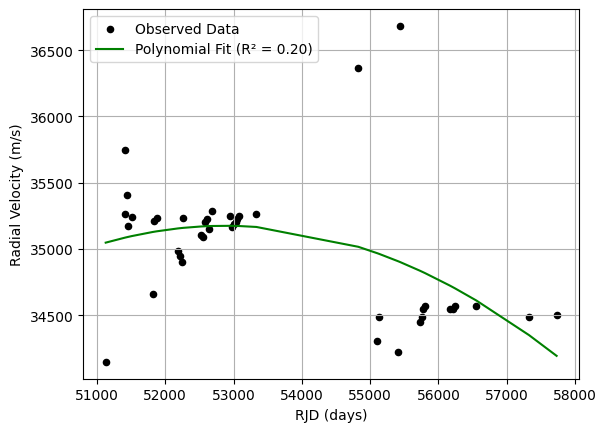

In [31]:
# Polynomial Regression (e.g., quadratic)
degree = 2  # Quadratic fit
coeffs = np.polyfit(df['rjd'], df['vrad'], degree)
poly_fit = np.polyval(coeffs, df['rjd'])
r2_poly = 1 - np.sum((df['vrad'] - poly_fit)**2) / np.sum((df['vrad'] - np.mean(df['vrad']))**2)

print(f"Polynomial (degree {degree}) Coefficients: {coeffs}")
print(f"R^2 (Polynomial): {r2_poly:.4f}")

# Plot
plt.scatter(df['rjd'], df['vrad'], color='black', label='Observed Data', s=20)
plt.plot(df['rjd'], poly_fit, color='green', label=f'Polynomial Fit (R² = {r2_poly:.2f})')
plt.xlabel('RJD (days)')
plt.ylabel('Radial Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

# Moving Average

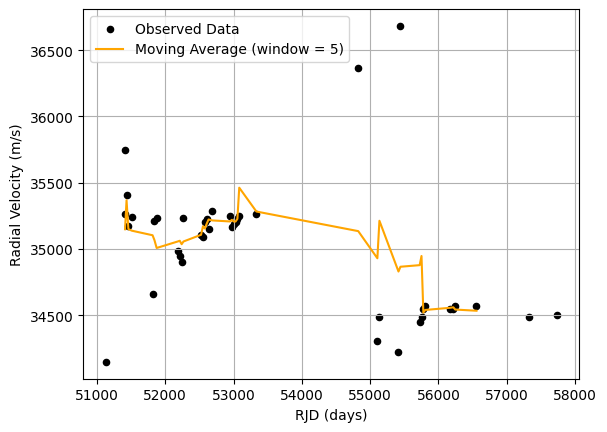

In [32]:
# Moving Average
window_size = 5  # Number of points to average
moving_avg = df['vrad'].rolling(window=window_size, center=True).mean()

# Plot
plt.scatter(df['rjd'], df['vrad'], color='black', label='Observed Data', s=20)
plt.plot(df['rjd'], moving_avg, color='orange', label=f'Moving Average (window = {window_size})')
plt.xlabel('RJD (days)')
plt.ylabel('Radial Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

# Constant Model

Constant Model: vrad = 35002.02
R^2 (Constant): 0.0000


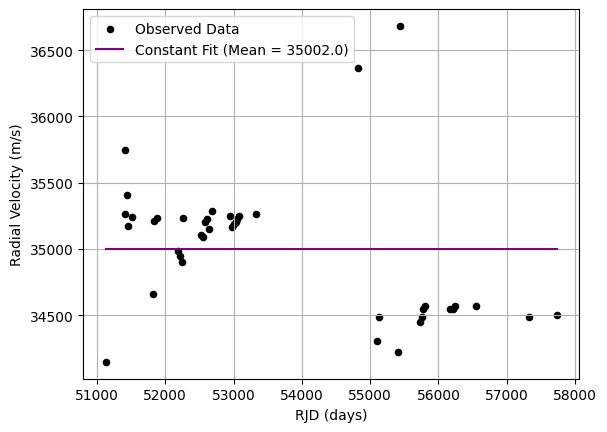

In [33]:
# Constant Model
mean_vrad = np.mean(df['vrad'])
constant_fit = np.full_like(df['vrad'], mean_vrad)
r2_const = 1 - np.sum((df['vrad'] - constant_fit)**2) / np.sum((df['vrad'] - mean_vrad)**2)

print(f"Constant Model: vrad = {mean_vrad:.2f}")
print(f"R^2 (Constant): {r2_const:.4f}")  # Will be 0 by definition

# Plot
plt.scatter(df['rjd'], df['vrad'], color='black', label='Observed Data', s=20)
plt.plot(df['rjd'], constant_fit, color='purple', label=f'Constant Fit (Mean = {mean_vrad:.1f})')
plt.xlabel('RJD (days)')
plt.ylabel('Radial Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

# Multiple Linear Regression

Multiple Linear Regression: vrad = 6.2513 * rjd + -72655.6163 * ha + -269713.72
R^2 (Multiple): 1.0000


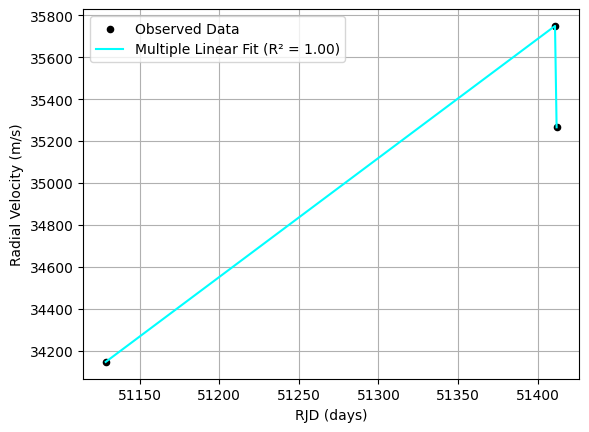

In [34]:
# Example: Add 'ha' from Document 1 (subset for brevity)
df['ha'] = pd.Series([0.216922, 0.219146, 0.225887] + [np.nan]*(len(df)-3))  # Placeholder
df = df.dropna()  # Drop rows with NaN for demo

# Multiple Linear Regression
from sklearn.linear_model import LinearRegression
X_multi = df[['rjd', 'ha']].values
y = df['vrad'].values
model = LinearRegression()
model.fit(X_multi, y)
multi_fit = model.predict(X_multi)
r2_multi = model.score(X_multi, y)

print(f"Multiple Linear Regression: vrad = {model.coef_[0]:.4f} * rjd + {model.coef_[1]:.4f} * ha + {model.intercept_:.2f}")
print(f"R^2 (Multiple): {r2_multi:.4f}")

# Plot (against rjd only for visualization)
plt.scatter(df['rjd'], df['vrad'], color='black', label='Observed Data', s=20)
plt.plot(df['rjd'], multi_fit, color='cyan', label=f'Multiple Linear Fit (R² = {r2_multi:.2f})')
plt.xlabel('RJD (days)')
plt.ylabel('Radial Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

# Guassian

GPR R^2: 1.0000


C:\Users\krish\anaconda3\envs\ANN\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


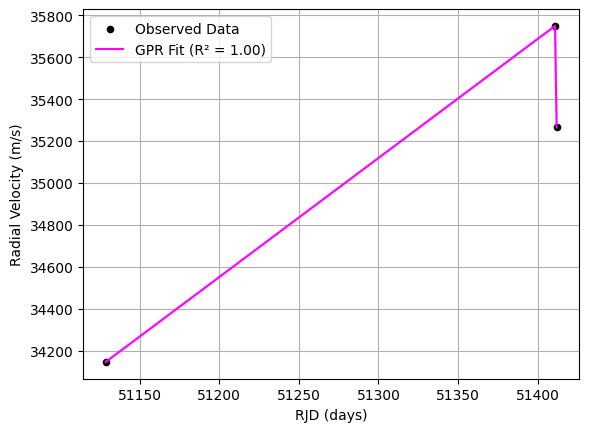

In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

# GPR
kernel = ConstantKernel(1.0) * RBF(length_scale=1000.0)  # Adjust length scale
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
X = df['rjd'].values.reshape(-1, 1)
y = df['vrad'].values
gpr.fit(X, y)
gpr_fit, gpr_std = gpr.predict(X, return_std=True)
r2_gpr = gpr.score(X, y)

print(f"GPR R^2: {r2_gpr:.4f}")

# Plot
plt.scatter(df['rjd'], df['vrad'], color='black', label='Observed Data', s=20)
plt.plot(df['rjd'], gpr_fit, color='magenta', label=f'GPR Fit (R² = {r2_gpr:.2f})')
plt.fill_between(df['rjd'], gpr_fit - gpr_std, gpr_fit + gpr_std, color='magenta', alpha=0.2)
plt.xlabel('RJD (days)')
plt.ylabel('Radial Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

Linear Regression: vrad = -0.1057 * rjd + 40672.20, R^2 = 0.1515
Sinusoidal Fit: vrad = 191.07 * sin(2π * rjd / 89.25 + -25.06) + 34995.23, R^2 = 0.0806
Polynomial (Quadratic) Fit: R^2 = 0.2039
Constant Model: vrad = 35002.02, R^2 = 0.0000
Piecewise Linear: R^2 = 0.2237
Robust Linear: vrad = 0.6640 * rjd + 0.00, R^2 = -9.2951


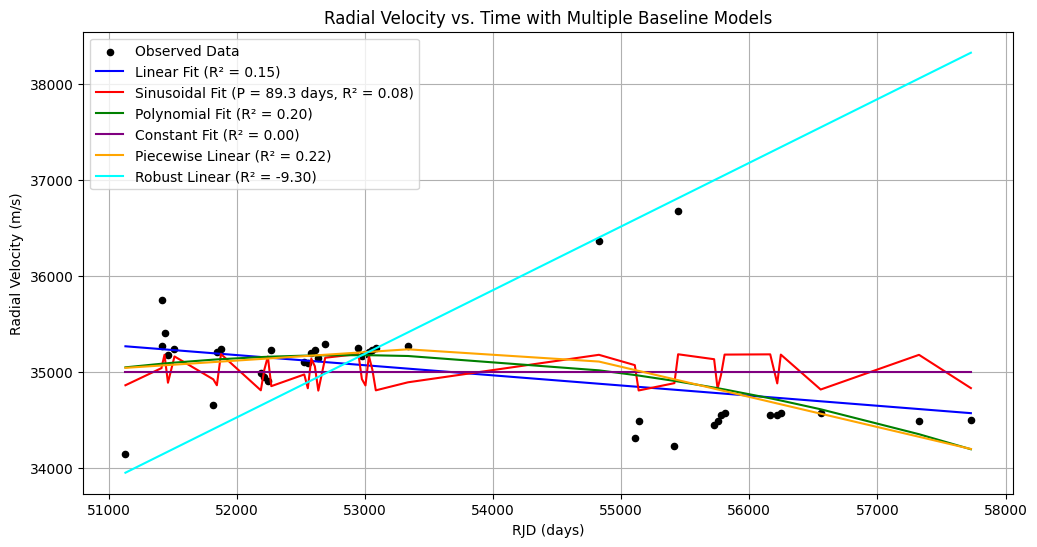

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import lombscargle
from sklearn.linear_model import HuberRegressor

# Combined data (same as before)
data_doc1 = [
    [54825.62970396, 36363.285933], [55105.76652554, 34306.805559], [55135.73754879, 34487.026370],
    [55414.89493338, 34222.026370], [55443.82919142, 36683.180159], [55724.92052929, 34447.026370],
    [55751.89493338, 34487.026370], [55778.82919142, 34547.026370], [55806.76652554, 34567.026370],
    [56162.92052929, 34547.026370], [56217.89493338, 34547.026370], [56245.82919142, 34567.026370],
    [56556.84090049, 34567.026370]
]
data_doc2 = [
    [57324.73754879, 34482.154051], [57729.64884533, 34502.154051]
]
data_doc6 = [
    [51128.69988344, 34146.745232], [51410.91666112, 35749.382131], [51411.92052929, 35265.886107],
    [51433.88845277, 35406.345182], [51460.81172707, 35172.737581], [51511.76594888, 35242.976813],
    [51814.79229856, 34657.495920], [51842.70208705, 35207.526676], [51874.66810881, 35234.099225],
    [52185.82919142, 34986.805379], [52212.73754879, 34948.767092], [52240.66810881, 34904.420766],
    [52267.61736113, 35232.425503], [52524.89493338, 35105.026676], [52552.82574727, 35088.805379],
    [52579.76652554, 35202.099225], [52607.70208705, 35226.099225], [52634.64884533, 35146.745232],
    [52688.61736113, 35288.420766], [52947.89493338, 35246.745232], [52974.82919142, 35166.745232],
    [53002.76594888, 35186.745232], [53029.70208705, 35206.745232], [53056.64884533, 35226.745232],
    [53083.61736113, 35246.745232], [53334.66810881, 35266.745232]
]

# Combine into DataFrame
combined_data = data_doc1 + data_doc2 + data_doc6
df = pd.DataFrame(combined_data, columns=['rjd', 'vrad'])
df = df.sort_values('rjd').reset_index(drop=True)

X = df['rjd'].values
y = df['vrad'].values

# 1. Linear Regression
slope, intercept = np.polyfit(X, y, 1)
linear_fit = slope * X + intercept
r2_linear = 1 - np.sum((y - linear_fit)**2) / np.sum((y - np.mean(y))**2)

# 2. Sinusoidal Model
def sinusoidal(t, K, P, phi, gamma):
    return K * np.sin(2 * np.pi * t / P + phi) + gamma

freqs = np.linspace(0.001, 0.1, 10000)
periods = 1 / freqs
power = lombscargle(X - X.min(), y - np.mean(y), freqs, precenter=True)
best_period = periods[np.argmax(power)]
initial_guess = [np.std(y), best_period, 0, np.mean(y)]
popt, pcov = curve_fit(sinusoidal, X, y, p0=initial_guess, maxfev=10000)
K, P, phi, gamma = popt
sine_fit = sinusoidal(X, K, P, phi, gamma)
r2_sine = 1 - np.sum((y - sine_fit)**2) / np.sum((y - np.mean(y))**2)

# 3. Polynomial Regression (Quadratic)
degree = 2
coeffs = np.polyfit(X, y, degree)
poly_fit = np.polyval(coeffs, X)
r2_poly = 1 - np.sum((y - poly_fit)**2) / np.sum((y - np.mean(y))**2)

# 4. Constant Model
mean_vrad = np.mean(y)
constant_fit = np.full_like(y, mean_vrad)
r2_const = 1 - np.sum((y - constant_fit)**2) / np.sum((y - np.mean(y))**2)

# 5. Piecewise Linear Regression
# Split at RJD = 54000 (between 53334 and 54825)
split_point = 54000
mask1 = X <= split_point
mask2 = X > split_point

# Fit two linear models
slope1, intercept1 = np.polyfit(X[mask1], y[mask1], 1)
slope2, intercept2 = np.polyfit(X[mask2], y[mask2], 1)
piecewise_fit = np.zeros_like(X)
piecewise_fit[mask1] = slope1 * X[mask1] + intercept1
piecewise_fit[mask2] = slope2 * X[mask2] + intercept2
r2_piecewise = 1 - np.sum((y - piecewise_fit)**2) / np.sum((y - np.mean(y))**2)

# 6. Robust Linear Regression
huber = HuberRegressor()
X_reshaped = X.reshape(-1, 1)
huber.fit(X_reshaped, y)
robust_fit = huber.predict(X_reshaped)
r2_robust = huber.score(X_reshaped, y)

# Print Results
print(f"Linear Regression: vrad = {slope:.4f} * rjd + {intercept:.2f}, R^2 = {r2_linear:.4f}")
print(f"Sinusoidal Fit: vrad = {K:.2f} * sin(2π * rjd / {P:.2f} + {phi:.2f}) + {gamma:.2f}, R^2 = {r2_sine:.4f}")
print(f"Polynomial (Quadratic) Fit: R^2 = {r2_poly:.4f}")
print(f"Constant Model: vrad = {mean_vrad:.2f}, R^2 = {r2_const:.4f}")
print(f"Piecewise Linear: R^2 = {r2_piecewise:.4f}")
print(f"Robust Linear: vrad = {huber.coef_[0]:.4f} * rjd + {huber.intercept_:.2f}, R^2 = {r2_robust:.4f}")

# Plot All Models
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='black', label='Observed Data', s=20)
plt.plot(X, linear_fit, color='blue', label=f'Linear Fit (R² = {r2_linear:.2f})')
plt.plot(X, sine_fit, color='red', label=f'Sinusoidal Fit (P = {P:.1f} days, R² = {r2_sine:.2f})')
plt.plot(X, poly_fit, color='green', label=f'Polynomial Fit (R² = {r2_poly:.2f})')
plt.plot(X, constant_fit, color='purple', label=f'Constant Fit (R² = {r2_const:.2f})')
plt.plot(X, piecewise_fit, color='orange', label=f'Piecewise Linear (R² = {r2_piecewise:.2f})')
plt.plot(X, robust_fit, color='cyan', label=f'Robust Linear (R² = {r2_robust:.2f})')
plt.xlabel('RJD (days)')
plt.ylabel('Radial Velocity (m/s)')
plt.title('Radial Velocity vs. Time with Multiple Baseline Models')
plt.legend()
plt.grid(True)
plt.show()


--- Training FNN with Engineered Features ---

--- Skipping Transformer (Needs more data) ---

--- Training Optimized GPR ---
Optimized GPR Kernel: 0.558**2 * RBF(length_scale=2.01e+03) + 0.597**2 * ExpSineSquared(length_scale=1.56, periodicity=572) + WhiteKernel(noise_level=0.66)

--- Training LSTM with Engineered Features ---

--- Final R^2 Scores ---
FNN (Eng. Feat.) R^2: 0.3583
GPR (Optimized) R^2: 0.4138
LSTM (Eng. Feat.) R^2: 0.4433


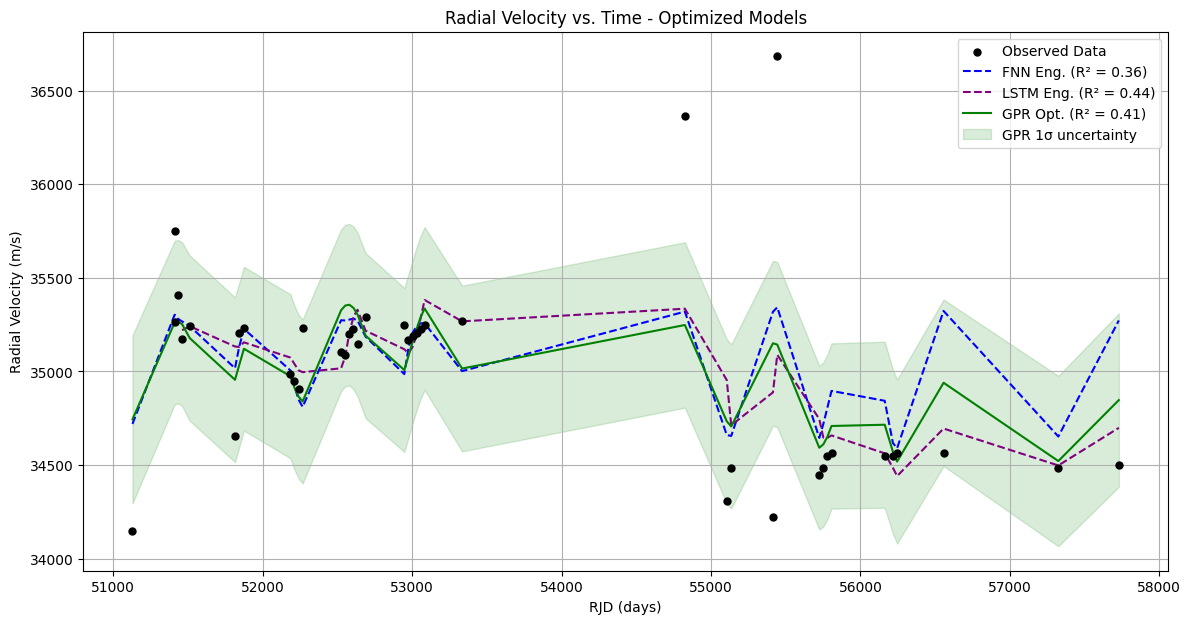

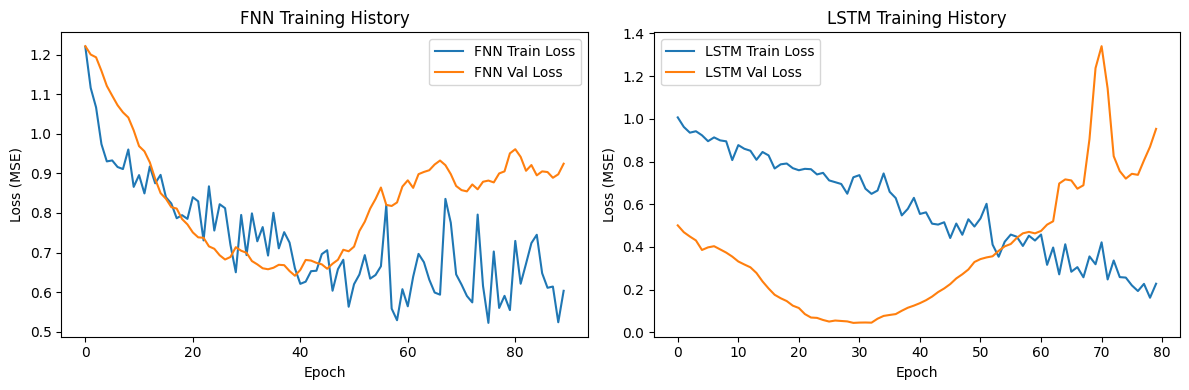

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, ConstantKernel
from sklearn.model_selection import train_test_split # Needed for potential NN validation improvement
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Layer, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

# --- Data Preparation (Same as before) ---
data_doc1 = [
    [54825.62970396, 36363.285933], [55105.76652554, 34306.805559], [55135.73754879, 34487.026370],
    [55414.89493338, 34222.026370], [55443.82919142, 36683.180159], [55724.92052929, 34447.026370],
    [55751.89493338, 34487.026370], [55778.82919142, 34547.026370], [55806.76652554, 34567.026370],
    [56162.92052929, 34547.026370], [56217.89493338, 34547.026370], [56245.82919142, 34567.026370],
    [56556.84090049, 34567.026370]
]
data_doc2 = [
    [57324.73754879, 34482.154051], [57729.64884533, 34502.154051]
]
data_doc6 = [
    [51128.69988344, 34146.745232], [51410.91666112, 35749.382131], [51411.92052929, 35265.886107],
    [51433.88845277, 35406.345182], [51460.81172707, 35172.737581], [51511.76594888, 35242.976813],
    [51814.79229856, 34657.495920], [51842.70208705, 35207.526676], [51874.66810881, 35234.099225],
    [52185.82919142, 34986.805379], [52212.73754879, 34948.767092], [52240.66810881, 34904.420766],
    [52267.61736113, 35232.425503], [52524.89493338, 35105.026676], [52552.82574727, 35088.805379],
    [52579.76652554, 35202.099225], [52607.70208705, 35226.099225], [52634.64884533, 35146.745232],
    [52688.61736113, 35288.420766], [52947.89493338, 35246.745232], [52974.82919142, 35166.745232],
    [53002.76594888, 35186.745232], [53029.70208705, 35206.745232], [53056.64884533, 35226.745232],
    [53083.61736113, 35246.745232], [53334.66810881, 35266.745232]
]

combined_data = data_doc1 + data_doc2 + data_doc6
df = pd.DataFrame(combined_data, columns=['rjd', 'vrad'])
df = df.sort_values('rjd').reset_index(drop=True)

# Use raw time for feature engineering, scaled time for direct NN input
X_raw_time = df['rjd'].values.reshape(-1, 1)
y_raw = df['vrad'].values

scaler_time = StandardScaler()
scaler_vrad = StandardScaler()

# Scale time for models that only use time
X_time_scaled = scaler_time.fit_transform(X_raw_time)
# Scale RV (target)
y_scaled = scaler_vrad.fit_transform(y_raw.reshape(-1, 1)).ravel()

# --- Feature Engineering: Add Sin/Cos terms ---
# Use the known period for HD 17289
P_known = 563.0
omega_known = 2 * np.pi / P_known

sin_feat = np.sin(omega_known * X_raw_time)
cos_feat = np.cos(omega_known * X_raw_time)

# Combine features: scaled_time, sin_feat, cos_feat
# Scale sin/cos features too? Usually not necessary, but can try.
X_combined_features = np.hstack([X_time_scaled, sin_feat, cos_feat])
num_features = X_combined_features.shape[1] # Should be 3

# --- Split Data (Example for NN validation - might still be too few points) ---
# Using a simple split here; time-series cross-validation would be better if more data
X_train, X_val, y_train, y_val = train_test_split(X_combined_features, y_scaled, test_size=0.2, shuffle=False, random_state=42)
X_time_scaled_train, X_time_scaled_val = train_test_split(X_time_scaled, test_size=0.2, shuffle=False, random_state=42)

# --- 1. Feedforward Neural Network (FNN) with Engineered Features ---
print("\n--- Training FNN with Engineered Features ---")
def build_fnn_eng():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(num_features,)), # Input shape matches combined features
        Dropout(0.2), # Reduced dropout
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse') # Slightly higher LR
    return model

fnn_model_eng = build_fnn_eng()
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) # Increased patience
history_fnn = fnn_model_eng.fit(X_train, y_train, epochs=1000, batch_size=4, verbose=0, # Smaller batch size
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predict on the full dataset for plotting/R2 calculation
fnn_pred_scaled = fnn_model_eng.predict(X_combined_features, verbose=0)
fnn_pred_eng = scaler_vrad.inverse_transform(fnn_pred_scaled).ravel()
r2_fnn_eng = 1 - np.sum((y_raw - fnn_pred_eng)**2) / np.sum((y_raw - np.mean(y_raw))**2)

# --- 2. Transformer (Skipping modification - needs more data/tuning) ---
print("\n--- Skipping Transformer (Needs more data) ---")
r2_transformer = -np.inf # Placeholder


# --- 3. Gaussian Process Regression - Optimized ---
print("\n--- Training Optimized GPR ---")
# Define bounds for hyperparameters, especially periodicity based on P_known
# Scale P_known by the time scaler's scale for the kernel, or use raw time?
# Let's fit GPR on RAW time X_raw_time to make kernel params interpretable.
# Target y_scaled is still scaled.

time_range = X_raw_time.max() - X_raw_time.min()
# Sensible bounds based on data and expected period
kernel_opt = (
    ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=time_range/4, length_scale_bounds=(time_range/20, time_range*2)) +
    ConstantKernel(1.0, (1e-3, 1e3)) * ExpSineSquared(length_scale=5.0, periodicity=P_known, # Initialize with P_known
                             length_scale_bounds=(1.0, time_range/10),
                             periodicity_bounds=(P_known*0.8, P_known*1.2)) + # Bounds around known P
    WhiteKernel(noise_level=np.std(y_scaled)/2, noise_level_bounds=(1e-5, 1e1)) # Noise based on target std dev
)

gpr_opt = GaussianProcessRegressor(kernel=kernel_opt, n_restarts_optimizer=15, # More restarts
                                 alpha=0.0) # Use WhiteKernel for noise

gpr_opt.fit(X_raw_time, y_scaled) # Fit on RAW time, scaled target
print("Optimized GPR Kernel:", gpr_opt.kernel_)

gpr_pred_scaled, gpr_std_scaled = gpr_opt.predict(X_raw_time, return_std=True)
gpr_pred_opt = scaler_vrad.inverse_transform(gpr_pred_scaled.reshape(-1, 1)).ravel()
# Scale std dev appropriately
gpr_std_opt = gpr_std_scaled * np.sqrt(scaler_vrad.var_[0]) if hasattr(scaler_vrad, 'var_') else gpr_std_scaled * scaler_vrad.scale_[0]
r2_gpr_opt = 1 - np.sum((y_raw - gpr_pred_opt)**2) / np.sum((y_raw - np.mean(y_raw))**2)


# --- 4. LSTM Model with Engineered Features ---
print("\n--- Training LSTM with Engineered Features ---")
seq_length = 5 # Keep sequence length small for sparse data

def create_sequences_multifeat(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length + 1):
        Xs.append(X[i:(i + seq_length)])
        ys.append(y[i + seq_length - 1]) # Predict the last point in sequence
    return np.array(Xs), np.array(ys)

X_seq_eng, y_seq_eng = create_sequences_multifeat(X_combined_features, y_scaled, seq_length)
# Split sequences for validation
X_seq_train, X_seq_val, y_seq_train, y_seq_val = train_test_split(
    X_seq_eng, y_seq_eng, test_size=0.2, shuffle=False, random_state=42)


def build_lstm_eng():
    model = Sequential([
        LSTM(20, activation='tanh', input_shape=(seq_length, num_features), return_sequences=False), # Smaller LSTM units
        Dropout(0.2),
        Dense(10, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

lstm_model_eng = build_lstm_eng()
history_lstm = lstm_model_eng.fit(X_seq_train, y_seq_train, epochs=500, batch_size=4, verbose=0, # Increased epochs
                       validation_data=(X_seq_val, y_seq_val), callbacks=[early_stopping])

# Predict on all sequences for plotting
lstm_pred_seq_scaled = lstm_model_eng.predict(X_seq_eng, verbose=0)
lstm_pred_eng = np.full_like(y_raw, np.nan) # Initialize with NaNs
lstm_pred_eng[seq_length-1:] = scaler_vrad.inverse_transform(lstm_pred_seq_scaled).ravel()
r2_lstm_eng = 1 - np.sum((y_raw[seq_length-1:] - lstm_pred_eng[seq_length-1:])**2) / np.sum((y_raw[seq_length-1:] - np.mean(y_raw[seq_length-1:]))**2)


# --- Print R^2 scores ---
print("\n--- Final R^2 Scores ---")
# print(f"Original FNN R^2: {r2_fnn:.4f}") # From previous run
# print(f"Original Transformer R^2: {r2_transformer:.4f}") # From previous run
# print(f"Original GPR R^2: {r2_gpr:.4f}") # From previous run
# print(f"Original LSTM R^2: {r2_lstm:.4f}") # From previous run
print(f"FNN (Eng. Feat.) R^2: {r2_fnn_eng:.4f}")
print(f"GPR (Optimized) R^2: {r2_gpr_opt:.4f}")
print(f"LSTM (Eng. Feat.) R^2: {r2_lstm_eng:.4f}")


# --- Plot Results ---
plt.figure(figsize=(14, 7))
plt.scatter(X_raw_time, y_raw, color='black', label='Observed Data', s=25, zorder=5)
# Plot original bad FNN for comparison? maybe not needed
plt.plot(X_raw_time, fnn_pred_eng, color='blue', linestyle='--', label=f'FNN Eng. (R² = {r2_fnn_eng:.2f})')
# Plot original bad LSTM? maybe not needed
plt.plot(X_raw_time, lstm_pred_eng, color='purple', linestyle='--', label=f'LSTM Eng. (R² = {r2_lstm_eng:.2f})')
# Plot Optimized GPR
plt.plot(X_raw_time, gpr_pred_opt, color='green', label=f'GPR Opt. (R² = {r2_gpr_opt:.2f})')
plt.fill_between(X_raw_time.ravel(), gpr_pred_opt - gpr_std_opt, gpr_pred_opt + gpr_std_opt, color='green', alpha=0.15, label='GPR 1σ uncertainty')

plt.xlabel('RJD (days)')
plt.ylabel('Radial Velocity (m/s)')
plt.title('Radial Velocity vs. Time - Optimized Models')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Plot training history for NNs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fnn.history['loss'], label='FNN Train Loss')
plt.plot(history_fnn.history['val_loss'], label='FNN Val Loss')
plt.title('FNN Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
plt.show()